<h1> Pokemon Classification Model </h1>

---

<p> Let's start by importing the important stuff that we need. Next we download the data, build the data pipeline, train the model, and then hopefully deploy the model on my blog.</p>

---

In [1]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *
import pandas as pd
import torch
import os

pd.set_option('display.max_rows', 500)
device = torch.device('mps')

I did some webscraping to download the images of the pokemon index as seen here: https://www.pokemon.com/us/pokedex. We collect the images as well as the first type for each of the 1010 pokemons.

In [4]:
df = pd.read_csv('data/pokemon_df.csv')
df['Ndex'] = df['Ndex'].apply(lambda x: int(x[1:]))
df

,Unnamed: 0,Ndex,MS,Pokémon,Type,Type.1
0,0,1,NaN,Bulbasaur,Grass,Poison
1,1,2,NaN,Ivysaur,Grass,Poison
2,2,3,NaN,Venusaur,Grass,Poison
3,3,4,NaN,Charmander,Fire,Fire
4,4,5,NaN,Charmeleon,Fire,Fire
...,...,...,...,...,...,...
1165,119,0,NaN,Ogerpon,Unknown,Unknown
1166,120,0,NaN,Okidogi,Unknown,Unknown
1167,121,0,NaN,Munkidori,Unknown,Unknown
1168,122,0,NaN,Fezandipiti,Unknown,Unknown


Here is the list of Pokemons. Interestingly sometimes there are two versions of the same pokemon such as different colors or shapes, but they have the same index numbering. Hence we select only the unique NDex pokemon id's and the first variants type and image. Next we sort the pictures based on type into different subfolders to make the loading into the dataloaders function easier.

In [ ]:
#| output: false
path_images = Path('data/pictures/pokemon_1.png')
# To create the folders of Pokemon Types
for type in df['Type'].unique():
    os.mkdir(f'data/pictures/{type}')

# Moving them in the correct folders
for i in range(1, len(df['Ndex'].unique())):
    frame = df.loc[df['Ndex'] == i]
    row = frame.iloc[0]
    type = row['Type']
    os.rename(f'data/pictures/pokemon_{i}.png', f'data/pictures/{type}/pokemon_{i}.png')

FileExistsError: [Errno 17] File exists: 'data/pictures/Grass'

In [11]:
# Building the datablock
get_image_files(path='data/pictures/')
path = Path('data/pictures/')
pokemons = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
# now we need to tell our datablock where our items are
dls = pokemons.dataloaders(path)

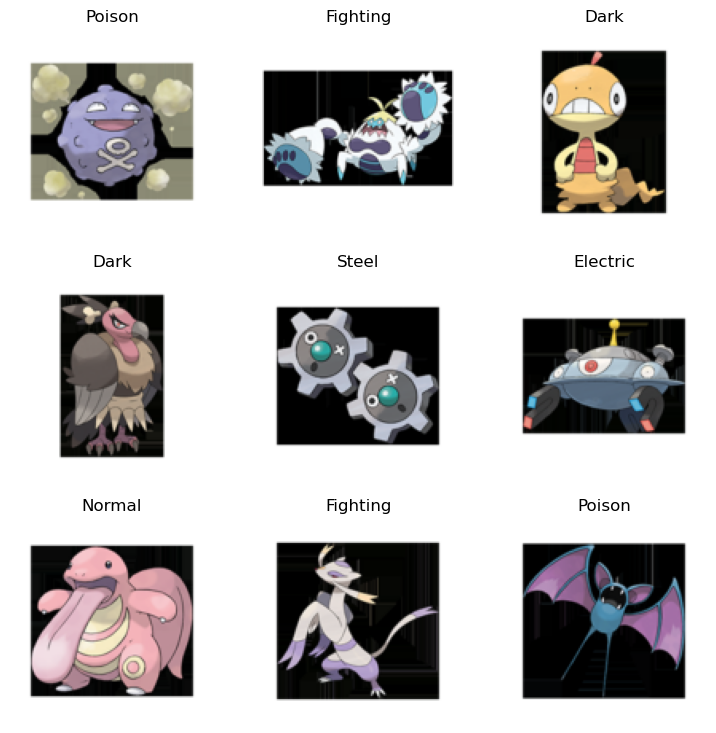

In [ ]:
#| label: batch-types
#| fig-cap: Data Input Batch
dls.valid.show_batch(max_n=9, nrows=3)

In [89]:
#| warning: false
# Train and learning
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,4.255514,3.037972,0.841584,00:05


epoch,train_loss,valid_loss,error_rate,time
0,3.232000,2.865299,0.787129,00:07
1,2.717485,2.688650,0.732673,00:06
2,2.179033,2.699625,0.717822,00:06
3,1.707126,2.728021,0.688119,00:06
4,1.326017,2.723592,0.698020,00:06
5,1.036368,2.749372,0.693069,00:06
6,0.828428,2.756829,0.702970,00:06
7,0.679754,2.762048,0.707921,00:06


In [94]:
# Exporting the weights so that we can put our model online on huggingface
learn.path = Path('.')
learn.export()

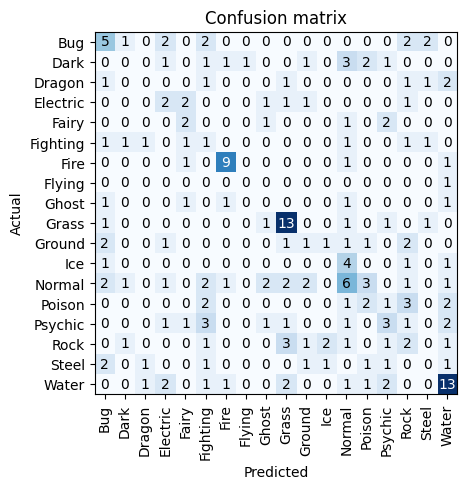

In [90]:
# Let's see the big Matrix
# |label: confusion-matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We take a look at the confusion matrix, which plots the predicted labels vs the actuals. We can see that the types "Fire, Grass, and Water" appear to be the easiest to identify. To any pokemon player this makes sense, as these three types are differently colored such as "red, green, and blue". As a last step we briefly look at the top losses of our classifier. Losses are the MSE (Mean Squared Error) a high loss indicates that our model did bad. There are further nuances to that such that it is especially bad if our model is wrong, but is very certain of the prediction. We can for example see a rock pokemon that was predicted to be a water pokemon, with a probability of 0.97

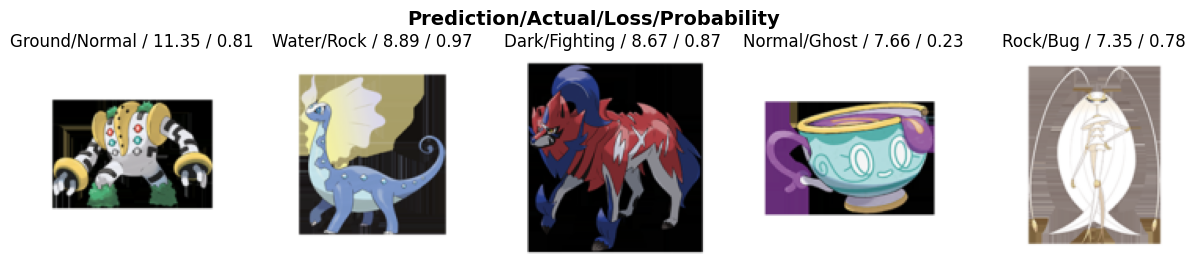

In [92]:
#| label: top_losses
interp.plot_top_losses(5, nrows=1)

Then again when looking at these images it seems tough to predict what type they are. Would you be able to? You can take a guess here: <a href='https://huggingface.co/spaces/BenjaminZeisberg/PokemonTypeClassifier'>PokemonTypeClassifier</a>